# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
#%matplotlib inline

In [7]:
%matplotlib inline

In [3]:
def plot_lightcurve(tus, start=None, stop=None):
  # Convert trigger times from seconds to minutes
     
    if start and stop != None:
        # Create a histogram of the trigger times
        plt.hist(tus, bins=100, range=(start, stop))
    else:
        plt.hist(tus, bins=100)
    # Set the x-axis label
    plt.xlabel('Time (s)')

    # Set the y-axis label
    plt.ylabel('Number of triggers')

    # Show the plot
    plt.show()

# Notes
    - The main burst in ASIM seems to be highly correlated with the first peak in FERMI data
    - tlagg = 1.79s to align it with the first peak
    - spectral analysis for T0+5.9s to T0+6.5s in FERMI ref frame (using tlagg=1.79s)
    
    
    -Suggest doing another CC to find the correct alignment. --> tlagg = +1.792s (aligning first spike)
    -Estimate background and subtract from tus_burst histogram
    -Find and label the 5 intervals for spectrum acc. See MM drawing
    
    

In [5]:
binsize = 0.064 #s
bins = np.arange(-0.5,10 + binsize,binsize)

# harvest data

dau/det starting from index 1
tus array given in seconds
safety time:  6.241 % removed
sorted by tus (s)


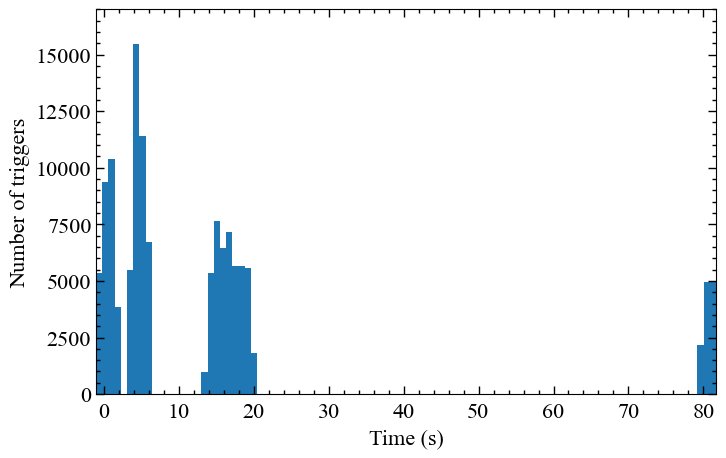

In [6]:
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)
tus = df['tus'].to_numpy()
T0 = datetime.fromisoformat('2021-12-11T13:10:01.323')
plot_lightcurve(tus=tus)

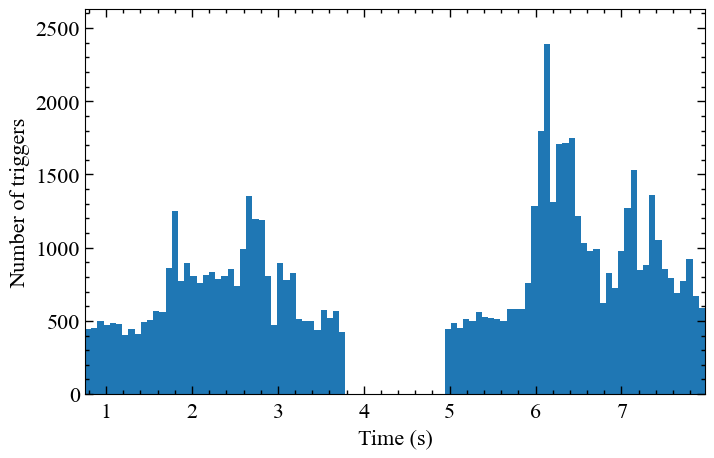

In [8]:
j = find_nearest(tus,10)
asim_tus = tus[:j] #+1.79
plot_lightcurve(tus=asim_tus+1.792)
#plot_HED(tus_arr=tus_burst*1e6,binsize=128,T0=T0+timedelta(seconds=1.79))

tus array OK ...


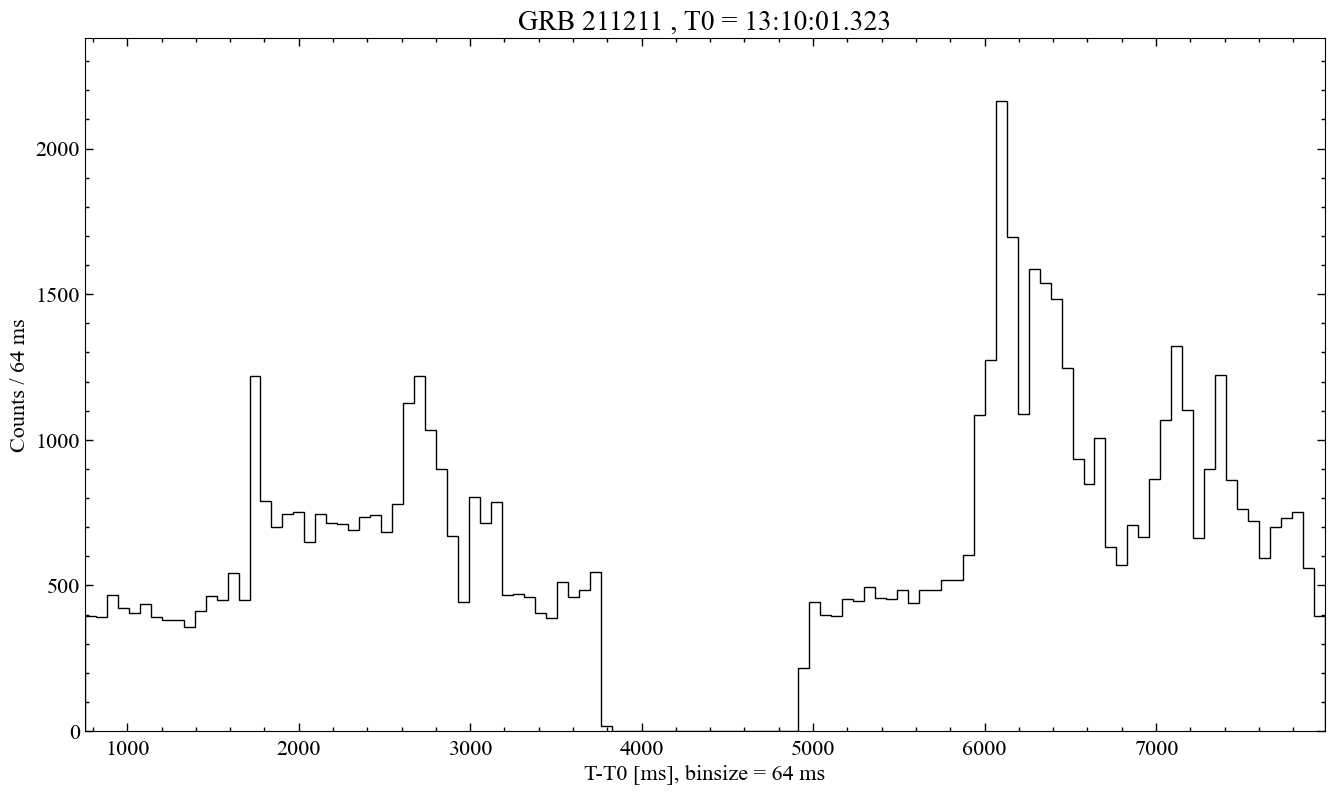

In [10]:
plot_HED(tus_arr=(asim_tus+1.792)*1e6,binsize=64,T0=T0)

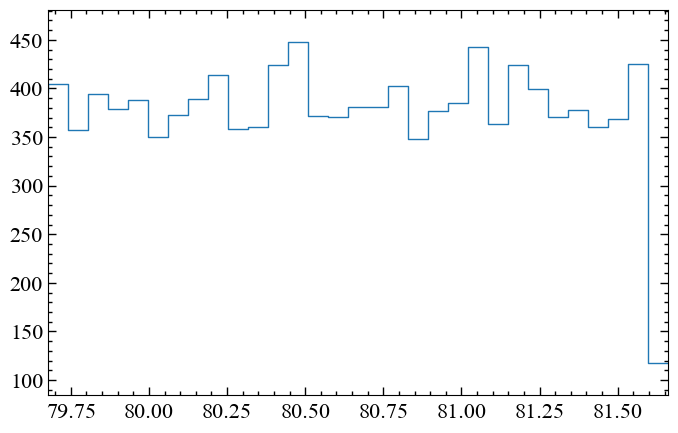

378.1875 cts/0.064 s


In [16]:
k = find_nearest(tus,78)
tus_bkg = tus[k:]
#plot_lightcurve(tus=tus_bkg)

hist_bkg = np.histogram(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize, binsize))
bkg_counts,bkg_edges = hist_bkg[0],hist_bkg[1]

plt.step(x=bkg_edges[:-1],y=bkg_counts)
plt.show()
bkg = np.mean(bkg_counts)
print(f'{bkg} cts/{binsize} s')

### Subtracting bkg from ASIM burst LC

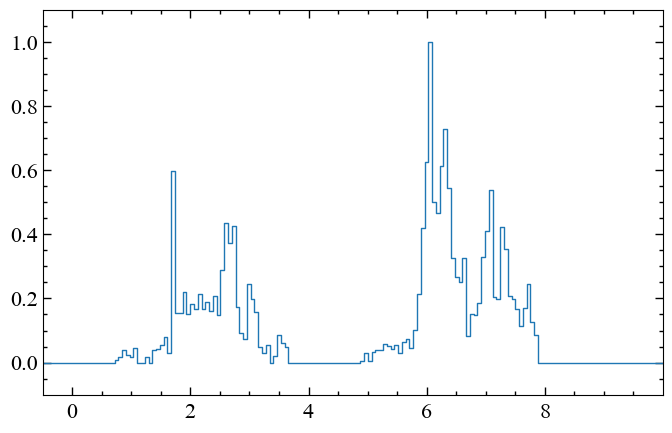

In [21]:
asim_counts,asim_edges = np.histogram(asim_tus+1.792,bins=bins)
asim_counts_no_bkg = np.clip(asim_counts-bkg,0,None)
plt.step(x=asim_edges[:-1],y=asim_counts_no_bkg/max(asim_counts_no_bkg))
plt.show()

## fermi data

In [2]:
GRB_id = "GRB211211A"
bn='bn211211549' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 212.271, 27.883  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn211211549_v01.fit
660921004.65092
['n2', 'na']
n2 28.936
na 49.853
n1 73.267
n5 75.59
b0 78.593
n9 84.886
n0 94.495
b1 101.407
nb 104.726
n3 128.519
n6 128.828
n4 130.308
n7 145.304
n8 149.746


In [14]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

n2


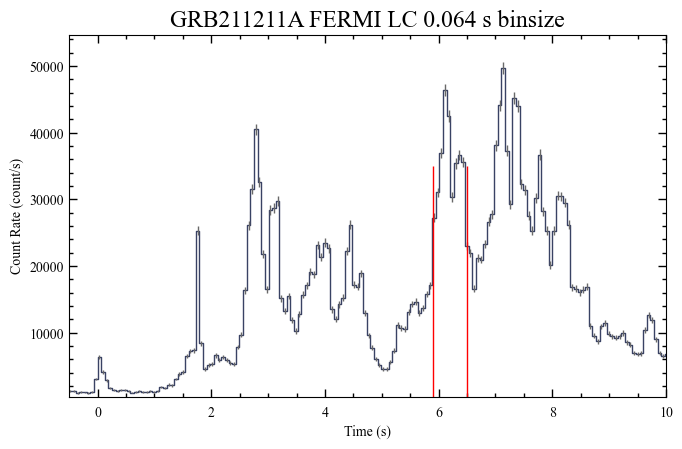

In [15]:
# open a TTE file
binsize=0.064

tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = binsize # 64ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8,1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,10)
lcplot.ax.set_title(f'GRB211211A FERMI LC {binsize} s binsize')
plt.vlines(x=5.9,ymin=0,ymax=35000,color='r')
plt.vlines(x=6.5,ymin=0,ymax=35000,color='r')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [27]:
tus_fermi = tte.data.time
ix,jx = find_nearest(tus_fermi,-0.5), find_nearest(tus_fermi,10)
tus_fermi = tus_fermi[ix:jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)

# super plots
    -already shifted asim_tus by 1.792s
    -fermi lc is the the 350-1e4 keV band

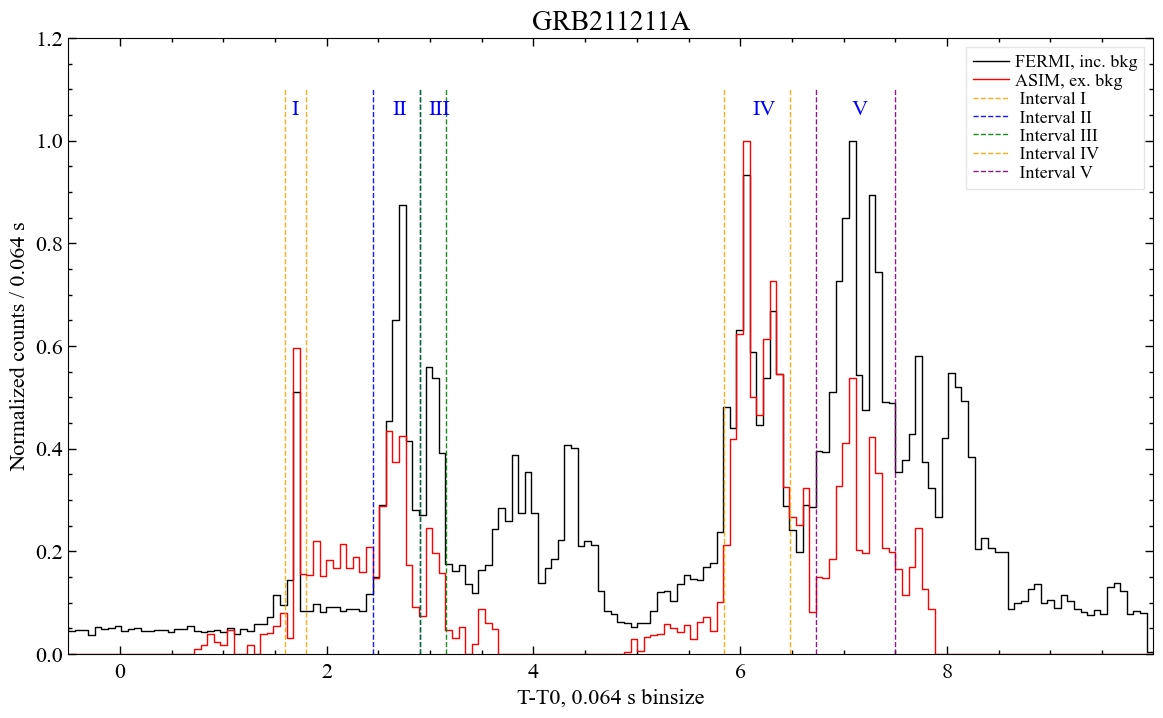

In [124]:
import roman
plt.figure(figsize=(14, 8))

plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),color='black',label='FERMI, inc. bkg')
plt.step(x=asim_edges[:-1],y=asim_counts_no_bkg/max(asim_counts_no_bkg),color='red',label='ASIM, ex. bkg')
plt.title('GRB211211A')
plt.xlabel(f'T-T0, {binsize} s binsize')
plt.ylabel(f'Normalized counts / {binsize} s')



P = [[1.60, 1.80],
     [2.45, 2.90],
     [2.90, 3.15],
     [5.84, 6.48],
     [6.73, 7.50]]

colors = ['Orange','Blue','Green','Orange', 'Purple']

for i, p in enumerate(P):
    plt.vlines(x=p, ymin=0,ymax=1.1, color=colors[i], alpha=0.9, linestyle= "--", label=f' Interval {roman.toRoman(i+1)} ')
    plt.text( ((p[1]+p[0]) / 2) - 0.04, 1.05, roman.toRoman(i+1), fontsize=16, c= "blue")


plt.ylim(bottom=0,top=1.2)
#plt.grid()
plt.legend()
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/GRB211211A_correlated_intervals.png')
plt.show()

# cross correlation

In [129]:
asim_lc = LC(time=asim_edges[:-1],counts=asim_counts,dt=binsize)
fermi_lc = LC(time=fermi_edges[:-1],counts=fermi_counts,dt=binsize)

cc = CC(fermi_lc,asim_lc,mode='full')
tlagg=cc.time_shift
print("Total lagg (s): ", tlagg)

Total lagg (s):  1.792


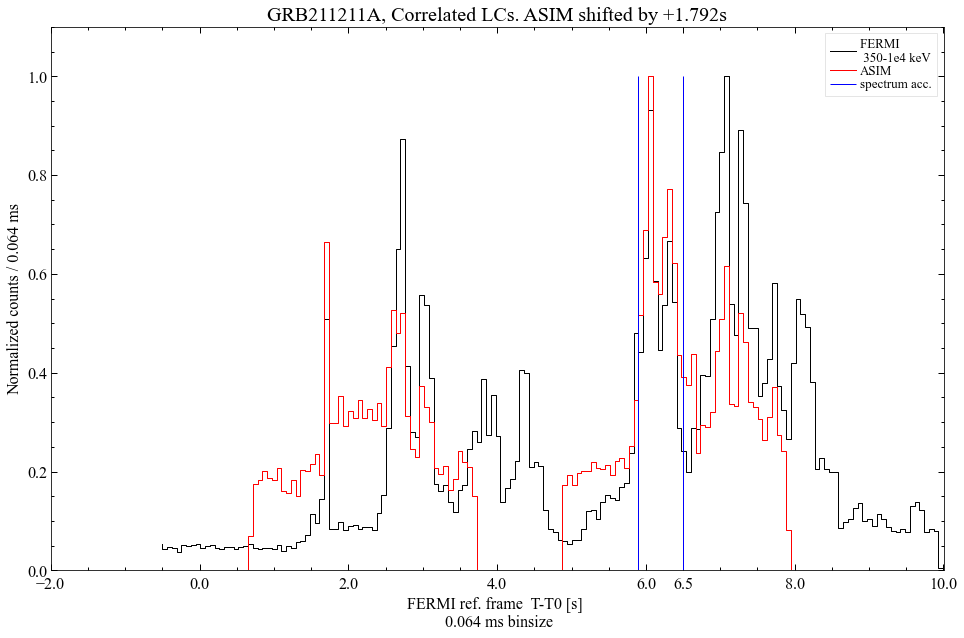

In [167]:
asim_tus_shift = asim_tus + tlagg
asim_hist_shift = np.histogram(asim_tus_shift,bins=bins)
asim_counts_shift,asim_edges_shift = asim_hist_shift[0],asim_hist_shift[1]


plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),color='black',label='FERMI \n 350-1e4 keV')
plt.step(x=asim_edges_shift[:-1],y=asim_counts_shift/max(asim_counts_shift),color='red',label='ASIM')
plt.title(f'GRB211211A, Correlated LCs. ASIM shifted by +{np.round(tlagg,3)}s')
plt.xlabel(f'FERMI ref. frame  T-T0 [s] \n {binsize} ms binsize')
plt.ylabel(f'Normalized counts / {binsize} ms')
#plt.grid()

plt.ylim(bottom=0,top=1.1)
plt.vlines(x=5.9,ymin=0,ymax=1,color='blue')
plt.vlines(x=6.5,ymin=0,ymax=1,color='blue',label='spectrum acc.')

extraticks = [6.5]
plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.legend()

#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/GRB211211A_correlated.png')
plt.show()

### cc results

# Extraction of FITS files

## ASIM extraction

In [4]:
#harvesting new dataframe and shifting by tlagg
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)

tlagg=1.79 #s

T0 = datetime.fromisoformat('2021-12-11T13:10:01.323')+timedelta(seconds=tlagg)
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus
print(T0)

dau/det starting from index 1
tus array given in seconds
safety time:  6.242 % removed
sorted by tus (s)
2021-12-11 13:10:03.113000


In [ ]:
i_start,i_end = find_nearest(tus,5.9),find_nearest(tus,6.5)
tus_burst = tus[i_start:i_end]
plot_HED(tus_arr=tus_burst*1e6,binsize=2,T0=T0)

In [126]:
df_burst = df.truncate(before=i_start,after=i_end)
#plot_HED(tus_arr=df_burst['tus'].to_numpy()*1e6,binsize=2,T0=T0) #same interval

In [127]:
df_keV = keV_hist(df=df_burst,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  13342
n triggers are within bounds  13342
keV bins are set for HED
Energies binned!


In [136]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [134]:
print('Exposure: ',np.round(tus_burst[-1]-tus_burst[0],3))
print(T0)

Exposure:  0.6
2021-12-11 13:10:03.113000


## Interval I-V
    -need 5 new pha files given by P
    -already have bak and rsp file
    
    looping over [t_start, t_end] in P

In [ ]:
# todo:
# check that the initial T0 is correct. Check RAW_DATETIME on server

In [20]:
#harvesting data
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323') 
df.sort_values(by='tus',inplace=True,ignore_index=True)

tlagg=1.79 #s

T0 = datetime.fromisoformat('2021-12-11T13:10:01.323') + timedelta(seconds=tlagg)
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus
print(f'T0: {T0}')

dau/det starting from index 1
tus array given in seconds
safety time:  6.242 % removed
sorted by tus (s)
T0: 2021-12-11 13:10:03.113000


In [22]:
#Only changing some values
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.6,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB211211A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB211211A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB211211A.pha','PHA filename'] #<str>  ('example.pha')
}

#intervals
P = [[1.60, 1.80],
     [2.45, 2.90],
     [2.90, 3.15],
     [5.84, 6.48],
     [6.73, 7.50]]

for i, t in enumerate(P):
    
    i_start, i_stop = find_nearest(tus,t[0]),find_nearest(tus,t[1])
    
    df_interval = df.truncate(before=i_start, after=i_stop)
    
    tus_interval = df_interval['tus'].to_numpy()

    pha_dict['TSTART'][0] = round(tus_interval[0],3)#t[0]
    pha_dict['TSTOP'][0] = round(tus_interval[-1],3)#t[1]
    pha_dict['EXPOSURE'][0] = round(tus_interval[-1]-tus_interval[0],3) #round(t[1]-t[0],3)
    pha_dict['FILENAME'][0] = f'HED_GRB211211A_{i+1}.pha'

    print(pha_dict['TSTART'][0],
    pha_dict['TSTOP'][0],
    pha_dict['EXPOSURE'][0])
    
    #creating spectrum
    df_keV = keV_hist(df=df_interval,time_interval='max',keV_interval='max',convert_seconds=False)
    bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
    bin_hi = df_keV['bins_keV'].to_numpy()[1:]
    err = df_keV['poisson_error_counts'].to_numpy()[1:]
    counts = df_keV['counts'].to_numpy()[1:]
    
    print(len(bin_lo),len(bin_hi),len(counts),len(err))
    generatePHA(PHA_dict=pha_dict,
                bin_lo=bin_lo,
                bin_hi=bin_hi,
                stat_err=err,
                counts=counts)

1.6 1.8 0.2
Computing whole spectrum (10-1e5 keV)
n triggers in time interval  2508
n triggers are within bounds  2508
keV bins are set for HED
Energies binned!
40 40 40 40
2.45 2.9 0.45
Computing whole spectrum (10-1e5 keV)
n triggers in time interval  6528
n triggers are within bounds  6528
keV bins are set for HED
Energies binned!
40 40 40 40
2.9 3.15 0.25
Computing whole spectrum (10-1e5 keV)
n triggers in time interval  2584
n triggers are within bounds  2584
keV bins are set for HED
Energies binned!
40 40 40 40
5.84 6.48 0.64
Computing whole spectrum (10-1e5 keV)
n triggers in time interval  13533
n triggers are within bounds  13533
keV bins are set for HED
Energies binned!
40 40 40 40
6.73 7.5 0.77
Computing whole spectrum (10-1e5 keV)
n triggers in time interval  10598
n triggers are within bounds  10598
keV bins are set for HED
Energies binned!
40 40 40 40


## Single file

### PHA

In [141]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.6,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB211211A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB211211A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB211211A.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [142]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK
    T0+80s background accumulation

In [ ]:
tus_bkg = df['tus'].to_numpy()
i_bkg_start = find_nearest(tus_bkg,80)
plot_lightcurve(tus=tus_bkg[i_bkg_start:])
df_bkg = df.truncate(before=i_bkg_start)
df_bkg

In [ ]:
df_kev_bkg = keV_hist(df_bkg,time_interval='max',keV_interval='max',convert_seconds=False)
df_kev_bkg

In [152]:
print('Exposure bkg',np.round(tus_bkg[i_bkg_start:][-1]-tus_bkg[i_bkg_start:][0],3))
print('start',round(tus_bkg[i_bkg_start:][0],3))
print('end',round(tus_bkg[i_bkg_start:][-1],3))

Exposure bkg 2.01
start 81.468
end 83.478


In [153]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [81.468,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [83.478,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [2.01,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [154]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [155]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.60,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [1]:
theta,phi = 112.775,-177.757
drm_path = '/Users/andreas/phys/master/GRB/xspec/ASIM/GRB211211A/'#'/Home/siv30/wad005/master/HED_DRM/data'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

NameError: name 'find_DRM_file' is not defined

In [157]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction

In [114]:
tus_fermi = tus_fermi[find_nearest(tus_fermi,5.9):find_nearest(tus_fermi,6.5)]

In [116]:
len(tus_burst),len(tus_fermi) #decent agreement

(13342, 13288)

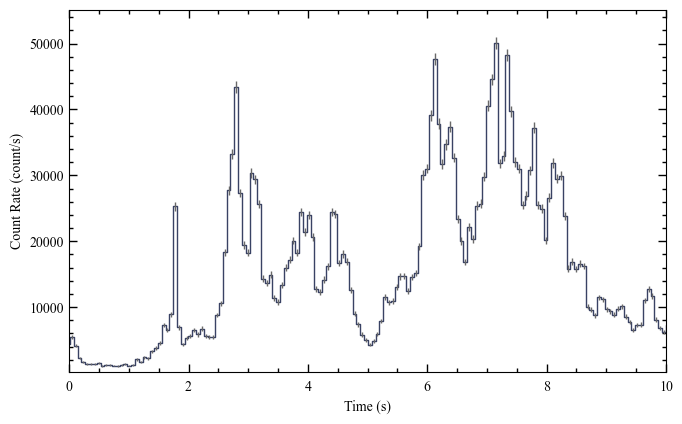

In [16]:
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = 0.064 # 4ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8, 1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (0,10)

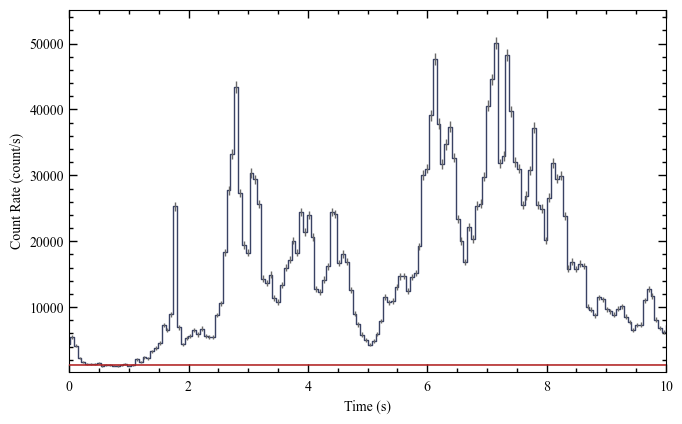

In [17]:
# Fit background
bkgd_times = [(-100.0, -2.0), (100,150)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (0,10)
lcplot.xlim = view_range

In [18]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([11.80446777,  2.08621819,  2.17591617,  1.85632733,  1.37532755,
        1.19027816,  0.97357563,  0.80555114,  0.8410191 ,  0.88929385,
        0.87580146,  0.87803346,  0.85837029,  0.8412321 ,  0.89817572,
        0.90430389,  0.82285671,  0.85415256,  0.81911115,  0.87671969,
        0.82754781,  0.86082419,  0.86108843,  0.8658914 ,  0.84079632,
        0.8803163 ,  1.05383517,  1.12407798,  1.21856584,  1.16695264,
        1.30994207,  1.33950303,  1.36487632,  1.13148378,  1.3451234 ,
        1.39887183,  1.54226643,  1.29321346,  1.38893832,  1.24091031,
        1.27577968,  1.34892864,  1.40610211,  1.73522078,  1.64702584,
        1.57059096,  1.90435459,  1.88266122,  2.18669543,  2.0841883 ,
        1.96328366,  2.1021902 ,  1.98695819,  2.16023743,  2.02825014,
        2.35726772,  2.45104641,  2.43413658,  2.26385501,  2.65397063,
        2.7057863 ,  2.50038542,  2.61626594,  2.71975972,  2.57543495,
        2.80209227,  2.73622124,  2.57979378,  2.67980813,  2.27

In [19]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= 0.000204  std= 1.01
NormaltestResult(statistic=6.31752181295279, pvalue=0.04247834312421403)


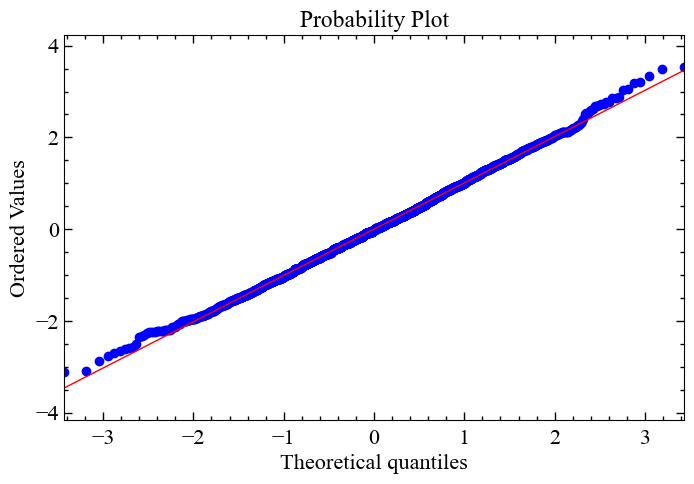

In [20]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

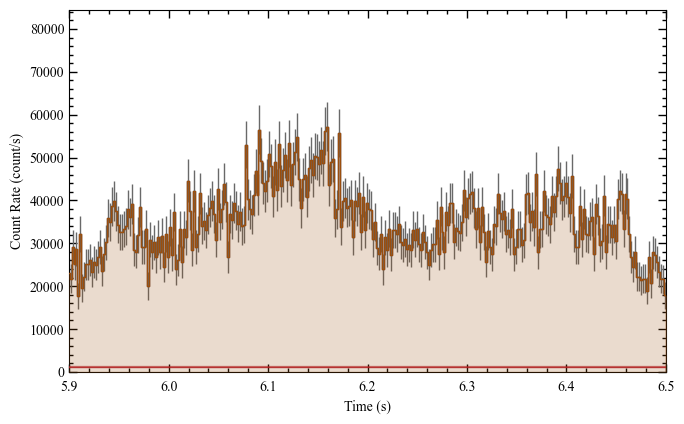

In [16]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (5.9,6.5)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

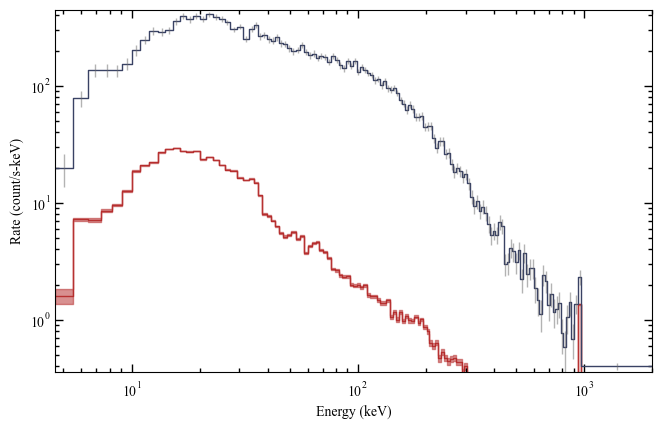

In [17]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [18]:
GRB_id = 'FERMI_GRB211211A'
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB211211A_n2.rsp FERMI_GRB211211A_n2.pha+2 RESPFILE


# FERMI fits interval extraction

In [21]:
#tcent: time_range / 2.0 -->therefor there will be pha,bak and rsp file for each interval


#intervals
P = [[1.60, 1.80],
     [2.45, 2.90],
     [2.90, 3.15],
     [5.84, 6.48],
     [6.73, 7.50]]

for i, p in enumerate(P):
    GRB_id = f'FERMI_GRB211211A_{i+1}'
    src_time = (p[0],p[1])
    pha = tte.to_pha(time_ranges=src_time)
    # the background spectrum
    bak = bkgd.to_bak(time_range=src_time)

    # So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
    # ```python
    fn_spectral = GRB_id + "_" + unit
    bak.write('./', filename=fn_spectral+'.bak')
    pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

    # Read RSP function
    rsp = RSP.open(fn_rsp)
    # and interpolate response files to get DRMs at center of the source window
    rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

    # Write response file
    rsp_interp.write('./', filename=fn_spectral+'.rsp')

    # It's advisable to set the RESPFILE keyword properly in the PHA file:
    print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")



fparkey FERMI_GRB211211A_1_n2.rsp FERMI_GRB211211A_1_n2.pha+2 RESPFILE
fparkey FERMI_GRB211211A_2_n2.rsp FERMI_GRB211211A_2_n2.pha+2 RESPFILE
fparkey FERMI_GRB211211A_3_n2.rsp FERMI_GRB211211A_3_n2.pha+2 RESPFILE
fparkey FERMI_GRB211211A_4_n2.rsp FERMI_GRB211211A_4_n2.pha+2 RESPFILE
fparkey FERMI_GRB211211A_5_n2.rsp FERMI_GRB211211A_5_n2.pha+2 RESPFILE
